In [3]:
import numpy as np
from experiments.utils.SimpleComparison import SimpleComparison
from hdimvis.algorithms.spring_force_algos.chalmers96_algo.Chalmers96 import Chalmers96
from hdimvis.visualise_layouts_and_metrics.plot import show_layout,show_generation_metrics
from hdimvis.algorithms.stochastic_ntet_algo.SNeD import SNeD
from hdimvis.create_low_d_layout.LayoutCreation import LayoutCreation
from hdimvis.data_fetchers.DataFetcher import DataFetcher
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from experiments.utils.get_avg_classwise_f1 import get_avg_classwise_f1
from experiments.utils.get_kmeans_f1 import get_kmeans_f1
from experiments.utils.get_f1_for_best_k_with_knn import get_f1_for_best_k_with_knn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from pathlib import Path
from definitions import PROJECT_ROOT
import pickle
from scipy import stats



squad
15


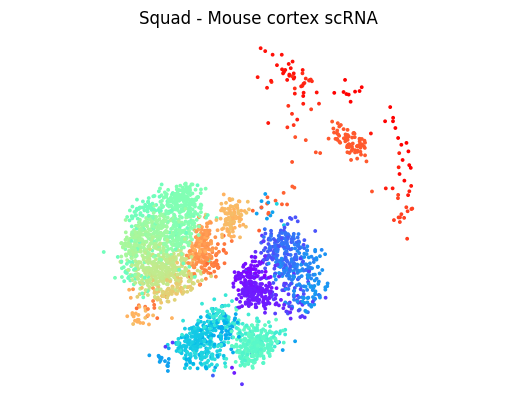

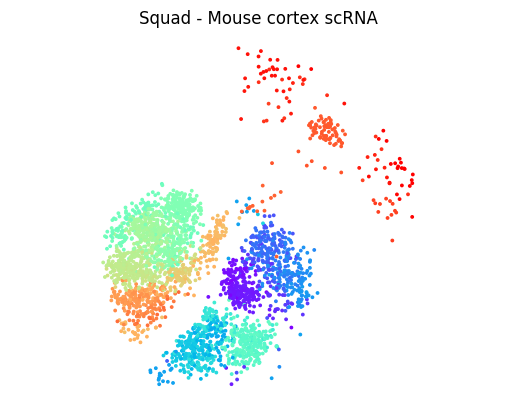

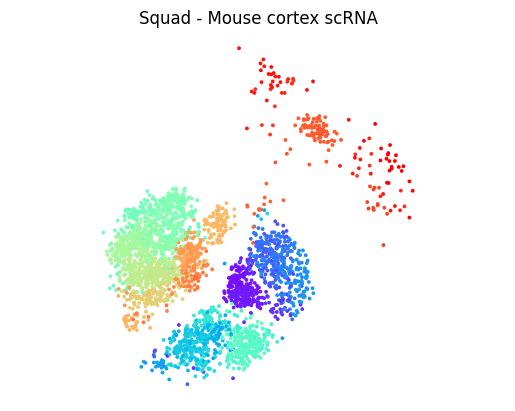

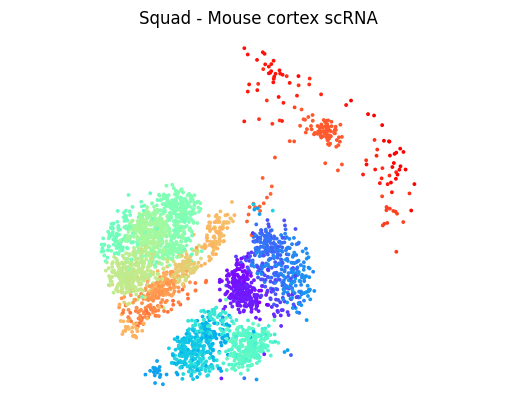

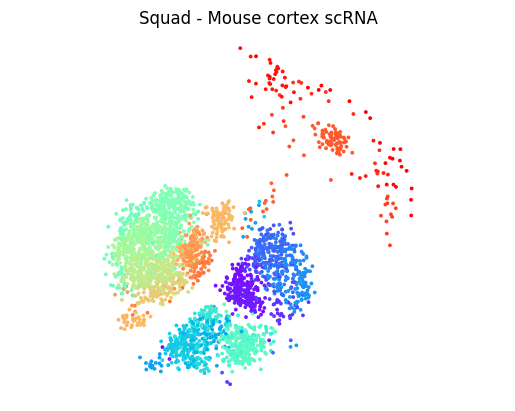

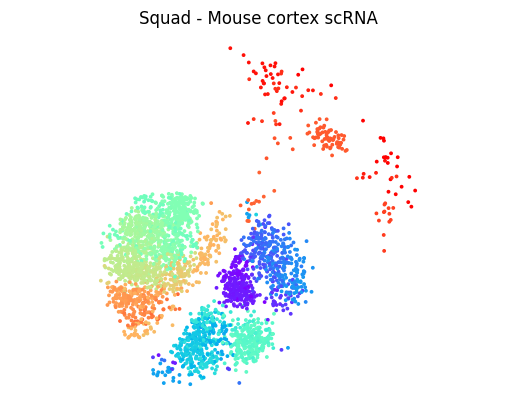

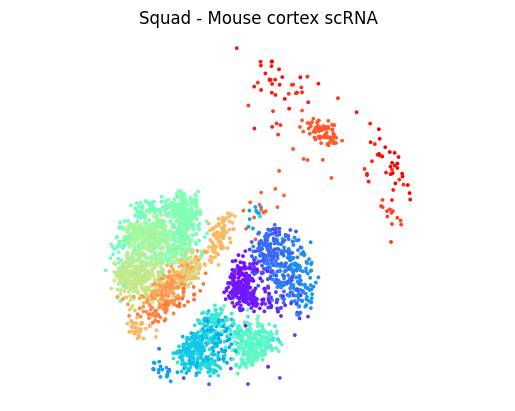

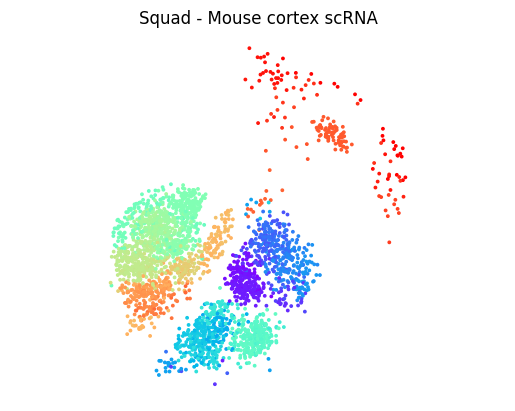

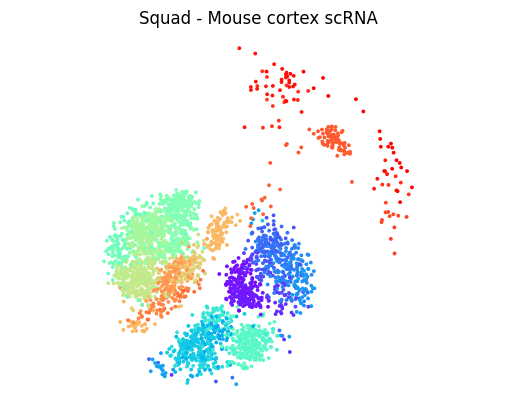

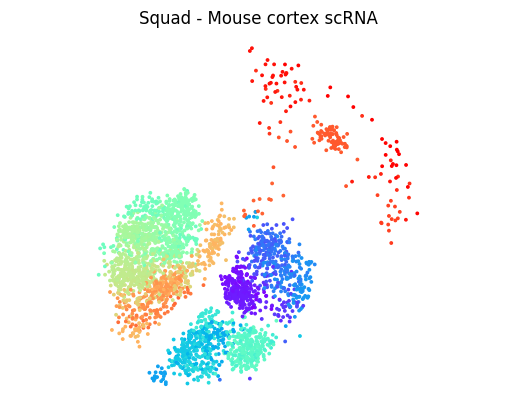

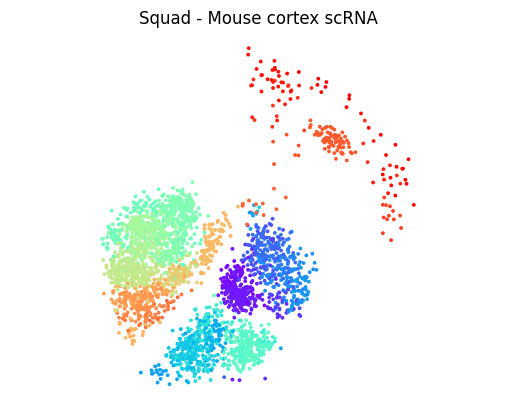

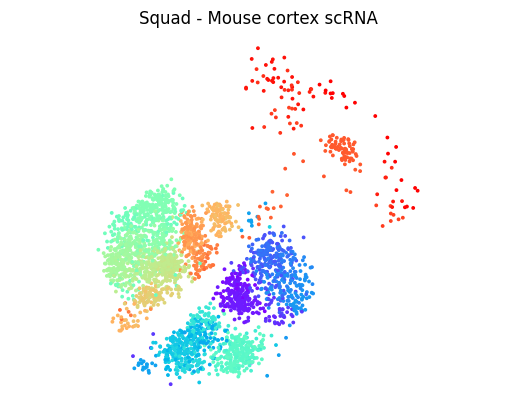

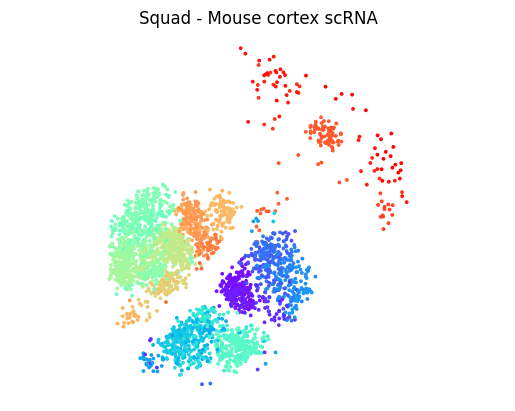

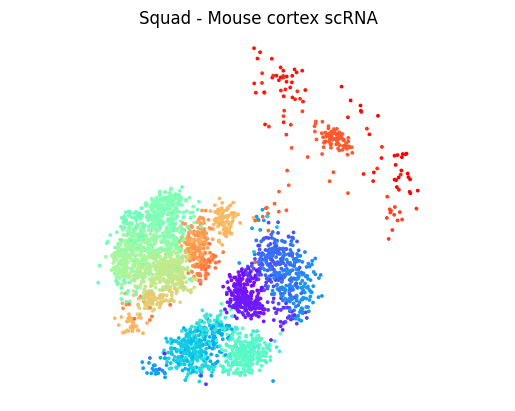

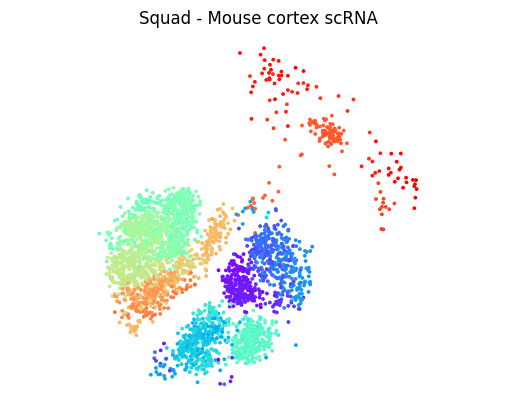

96
15


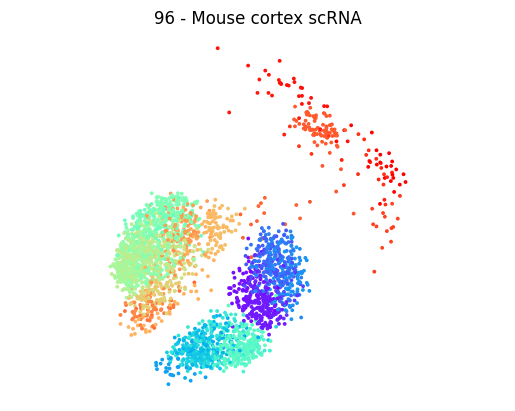

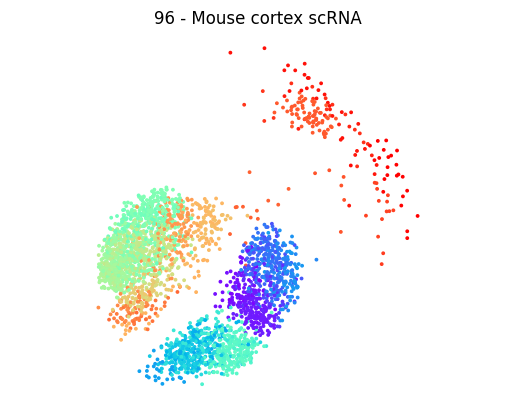

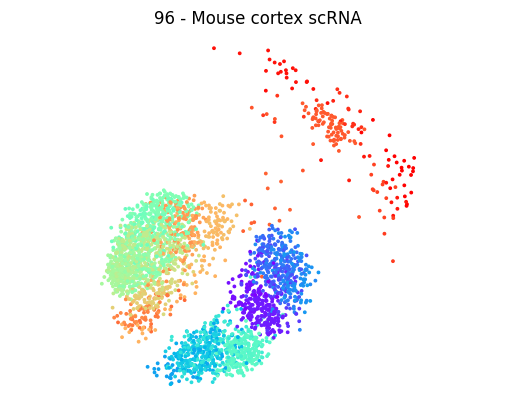

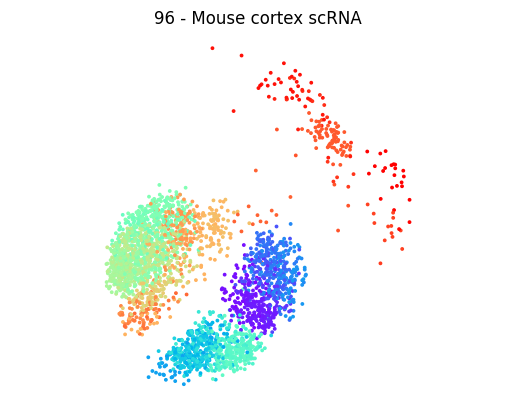

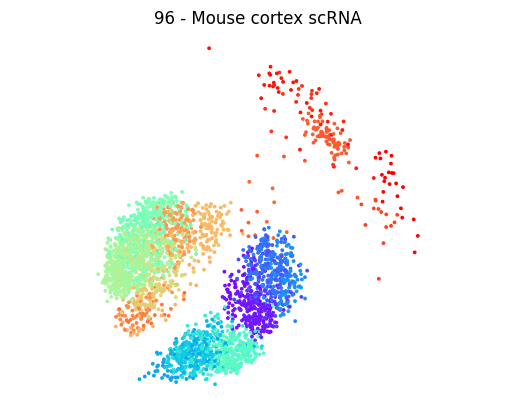

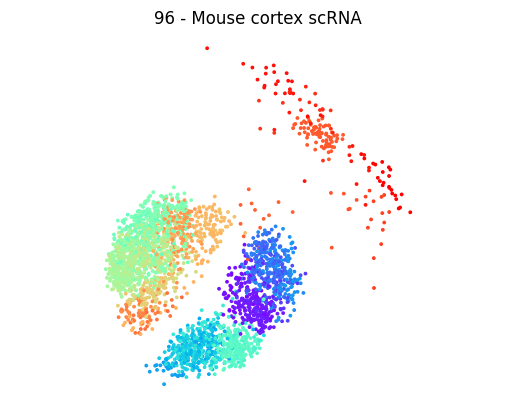

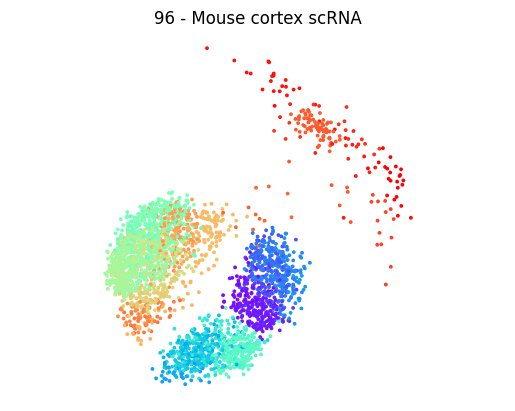

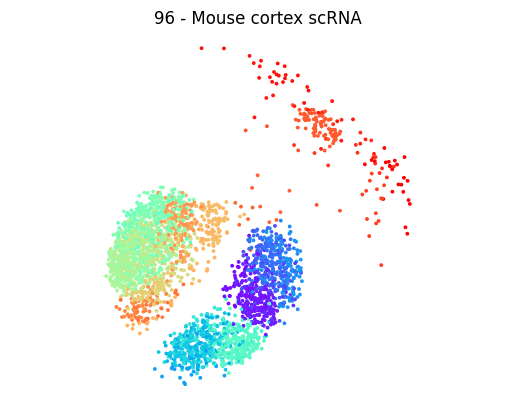

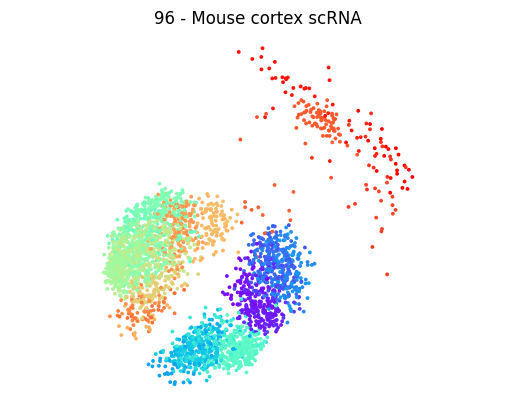

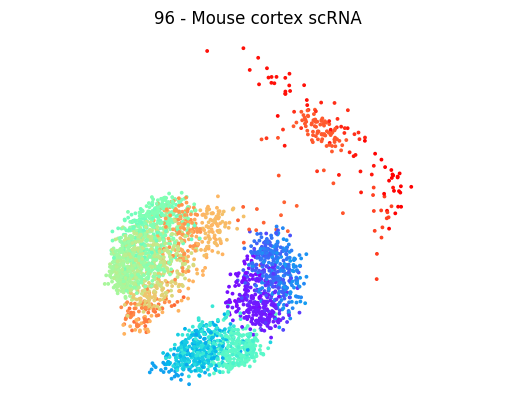

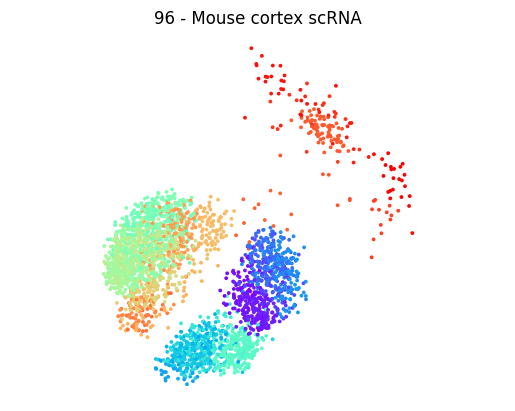

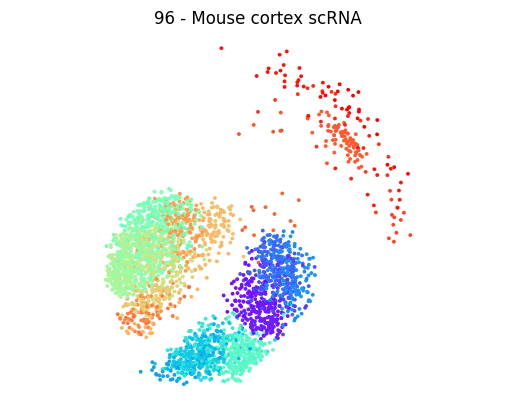

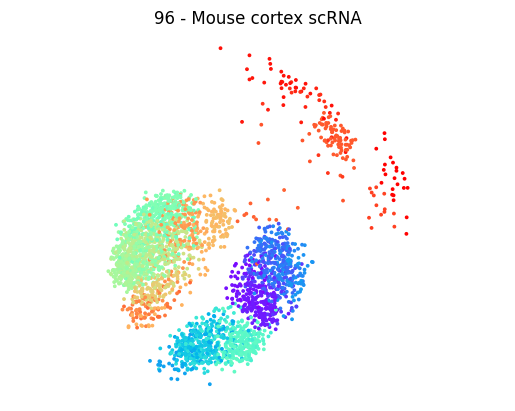

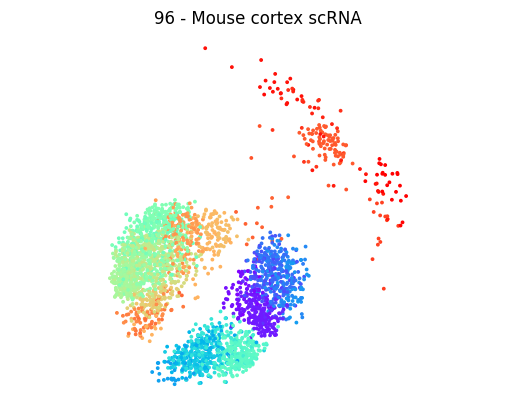

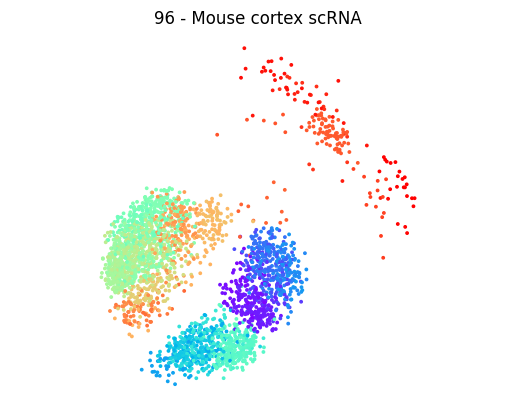

In [15]:
output_dir= (Path(PROJECT_ROOT).joinpath(
    Path(f"experiments/sned_vs_96/out/"))).resolve().absolute()



dataset_name = 'ran N3k'
path_to_pickle = (Path(output_dir).joinpath(Path(f"layouts_{dataset_name}.pickle"))).resolve()
with open(path_to_pickle, 'rb') as file:
    layouts = pickle.load(file)

for type, layouts in layouts.items():
    print(type)
    print(len(layouts))
    for l in layouts:
        show_layout(l, use_labels=True, title=f"{type.capitalize()} - Mouse cortex scRNA")



In [1]:
# for name, dict in layouts.items():
#     print(name)
#     for type, ls in dict.items():
#         print(type)
#         for l in ls:
#             print(l.iteration_number)

NameError: name 'layouts' is not defined

In [22]:
dataset_names = ['ran N3k']
# 'coli20', 'globe', 'fashion mnist', 'mnist']
output_dir= (Path(PROJECT_ROOT).joinpath(
    Path(f"experiments/sned_vs_96/out/"))).resolve().absolute()

for dataset_name in dataset_names:
    path_to_pickle = (Path(output_dir).joinpath(Path(f"layouts_{dataset_name}.pickle"))).resolve()
    with open(path_to_pickle, 'rb') as file:
        layouts = pickle.load(file)

    results_arr = np.zeros((2,15,4))
    print(dataset_name)
    for j, version in enumerate(["squad", "96"]):
        for i,layout in enumerate(layouts[version]):
            print(f"Layout: {i}")
            stress = layout.get_final_stress()
            kmeans_f1 = get_kmeans_f1(layout.get_final_positions(), layout.labels)
            k, f1_for_best_k_with_knn =  get_f1_for_best_k_with_knn(lower_bound=1, upper_bound=30,
                                                                cross_validation_folds=10,
                                                                 data=layout.data,
                                                                 labels=layout.labels)

            results_arr[j,i,0] = stress
            results_arr[j,i,1] = kmeans_f1
            results_arr[j,i,2],results_arr[j,i,3] =k,  f1_for_best_k_with_knn

    print(results_arr)
    output_dir= (Path(PROJECT_ROOT).joinpath(
        Path(f"experiments/sned_vs_96/out/"))).resolve().absolute()

    path_to_pickle_arr = (Path(output_dir).joinpath(Path(f"results_arr_rna.pickle"))).resolve()
    with open(path_to_pickle_arr, 'wb') as pickle_out:
        pickle.dump(results_arr, pickle_out)

ran N3k
Layout: 0

 Computing vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Layout: 1

 Computing vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Layout: 2

 Computing vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Layout: 3

 Computing vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Layout: 4

 Computing vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Layout: 5

 Computing vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Layout: 6

 Computing vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Layout: 7

 Computing vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Layout: 8

 Computing vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Layout: 9

 Computing vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Layout: 10

 Computing vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Layout: 11

 Computing vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Layout: 12

 Computing vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Layout: 13

 Computing vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Layout: 14

 Computing vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Layout: 0

 Computing vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Layout: 1

 Computing vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Layout: 2

 Computing vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Layout: 3

 Computing vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Layout: 4

 Computing vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Layout: 5

 Computing vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Layout: 6

 Computing vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Layout: 7

 Computing vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Layout: 8

 Computing vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Layout: 9

 Computing vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Layout: 10

 Computing vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Layout: 11

 Computing vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Layout: 12

 Computing vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Layout: 13

 Computing vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Layout: 14

 Computing vectorised euclidean stress 



C:\Users\Owner\.virtualenvs\2095736w-0SnFieZ0\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[[1.47620275 0.1971971  1.         0.79959343]
  [1.47869528 0.19957674 1.         0.79959343]
  [1.47725434 0.20249707 1.         0.79959343]
  [1.48270495 0.20719025 1.         0.79959343]
  [1.47589603 0.19890827 1.         0.79959343]
  [1.47400933 0.21555075 1.         0.79959343]
  [1.47761904 0.19272418 1.         0.79959343]
  [1.48235585 0.21767846 1.         0.79959343]
  [1.48209885 0.20660217 1.         0.79959343]
  [1.47312531 0.19378413 1.         0.79959343]
  [1.4787756  0.20738562 1.         0.79959343]
  [1.47863109 0.18723145 1.         0.79959343]
  [1.47946483 0.19953452 1.         0.79959343]
  [1.47383413 0.20121227 1.         0.79959343]
  [1.47385252 0.2036663  1.         0.79959343]]

 [[0.26374484 0.14154301 1.         0.79959343]
  [0.26344761 0.14383758 1.         0.79959343]
  [0.26362189 0.13666778 1.         0.79959343]
  [0.26341578 0.13381277 1.         0.79959343]
  [0.26358776 0.13152285 1.         0.79959343]
  [0.26359071 0.14043168 1.         0.

In [ ]:
from hdimvis.data_fetchers.DataFetcher import DataFetcher
from hdimvis.metrics.distance_measures.euclidian_and_manhattan import manhattan,euclidean
from hdimvis.algorithms.spring_force_algos.chalmers96_algo.Chalmers96 import Chalmers96
from hdimvis.create_low_d_layout.LayoutCreation import LayoutCreation
from hdimvis.visualise_layouts_and_metrics.plot import show_layout, show_generation_metrics
from sklearn.decomposition import PCA
from time import perf_counter
import numpy as np
from pathlib import Path
from definitions import PROJECT_ROOT
import pickle

rna = DataFetcher.fetch_data('rna N3k')
datasets = [rna]
dataset_names = ['rna N3k']
# datasets =[globe]
# dataset_names = ['globe']
max = 20
num_repeats = 3
results = {dataset_name: (np.zeros((max, max, num_repeats)),
                          [[[None for k in range(num_repeats)] for j in range(max)] for i in range(max)])
           for dataset_name in dataset_names}

for i, dataset in enumerate(datasets):
    n_neigh = 1
    n_sample = 1
    while n_neigh <= max:
        while n_sample <= max:
            print(f" n sample: {n_sample}")
            print(f" n_neigh {n_neigh}")

            for j in range(num_repeats):
                print(f" n sample -1: {n_sample - 1}")
                print(f" n_neigh -1  {n_neigh - 1}")
                algo96 = Chalmers96(dataset=dataset, distance_fn=euclidean,
                                    damping_constant=0, spring_constant=0.5,
                                    use_knnd=False, sample_set_size=n_neigh, neighbour_set_size=n_sample)
                start = perf_counter()
                layout = LayoutCreation.create_layout(algo96, no_iters=100)
                results[dataset_names[i]][0][n_neigh - 1, n_sample - 1, j] = perf_counter() - start
                results[dataset_names[i]][1][n_neigh - 1][n_sample - 1][j] = layout
            n_sample += 1
        n_sample = 1
        n_neigh += 1

output_dir = (Path(PROJECT_ROOT).joinpath(
    Path(f"experiments/varing_V_and_S/out/"))).resolve().absolute()

path_to_pickle = (Path(output_dir).joinpath(Path(f"results_rna.pickle"))).resolve()
with open(path_to_pickle, 'wb') as pickle_out:
    pickle.dump(results, pickle_out)

In [26]:
dataset_name = 'globe'
output_dir= (Path(PROJECT_ROOT).joinpath(
    Path(f"experiments/sned_vs_96/out/"))).resolve().absolute()
path_to_pickle = (Path(output_dir).joinpath(Path(f"results_arr_{dataset_name}.pickle"))).resolve()
with open(path_to_pickle, 'rb') as file:
    results_arr = pickle.load(file)


for j,metric in enumerate(["stress", "kmeans", "k", "knn"]):

        if j != 2:
            mean_squad = np.mean(results_arr[0,:,j])
            sd_squad = np.std(results_arr[0,:,j])

            mean_96 = np.mean(results_arr[1,:,j])
            sd_96 = np.std(results_arr[1,:,j])

            if j != 3:
                tstat, pvalue = stats.ttest_ind(results_arr[0,:,j].round(decimals=2), results_arr[1,:,j].round(decimals=2), equal_var=False, alternative='greater')
                result = np.format_float_scientific(pvalue, precision=2,min_digits=2)

            else:
                tstat, pvalue = stats.ttest_ind(results_arr[0,:,j].round(decimals=2), results_arr[1,:,j].round(decimals=2), equal_var=False, alternative='two-sided')
                result = np.format_float_scientific(pvalue, precision=2,min_digits=2)
            print(20*"#")
            print(f"Metric : {metric}")
            print(20*"#")


            print(f"Squad mean : {mean_squad.round(decimals=2)} (SD {sd_squad.round(decimals=2)})")
            print(f"96 mean : {mean_96.round(decimals=2)} (SD {sd_96.round(decimals=2)})")
            print(f"test: {result}")
        else:
            print(f"Squad mean k: {np.mean(results_arr[0,:,j])}")
            print(f"96 mean k: {np.mean(results_arr[1,:,j])}")




####################
Metric : stress
####################
Squad mean : 0.95 (SD 0.0)
96 mean : 0.13 (SD 0.0)
test: 6.77e-229
####################
Metric : kmeans
####################
Squad mean : 0.81 (SD 0.0)
96 mean : 0.8 (SD 0.0)
test: 1.92e-06
Squad mean k: 1.0
96 mean k: 1.0
####################
Metric : knn
####################
Squad mean : 0.95 (SD 0.0)
96 mean : 0.95 (SD 0.0)
test: 1.00e+00


C:\Users\Owner\AppData\Local\Temp\ipykernel_16656\2104122956.py:19: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  tstat, pvalue = stats.ttest_ind(results_arr[0,:,j].round(decimals=2), results_arr[1,:,j].round(decimals=2), equal_var=False, alternative='greater')
C:\Users\Owner\AppData\Local\Temp\ipykernel_16656\2104122956.py:23: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  tstat, pvalue = stats.ttest_ind(results_arr[0,:,j].round(decimals=2), results_arr[1,:,j].round(decimals=2), equal_var=False, alternative='two-sided')
